# Tensorflow & Keras によるニューラルネットワーク（NN）入門（LSTM編）

In [1]:
# いつものモジュールをインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import time

# Tensorflow & Keras
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation
from tensorflow.keras.optimizers import SGD, Adam

# 系列データの予測を，まず正弦波で練習

正弦波は周期波形なので，LSTMでかなり正確に予測できる（はず）

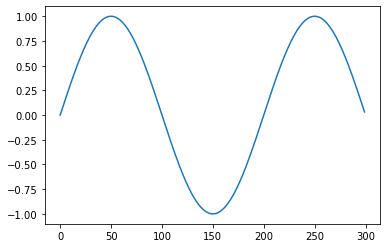

In [2]:
# 正弦波（sin）のデータを作成
i = np.arange(0, np.pi * 3, np.pi/100)
n = np.random.rand(len(i)) * 0.5
sine_data = np.sin(i)

plt.plot(sine_data)

In [3]:
# 系列データ data から学習データ（長さ size ）と正解データの組を準備する関数
def prepare_batch(data, size):
    if len(data) <= size:
        return None

    z = np.array(data).shape
    if len(z) > 1:
        dim = z[1]
    else:
        dim = 1
    
    x = []
    y = []
    n = len(data) - size
    
    for i in range(n):
        x.append(np.array(data[i:i + size]))
        y.append(data[i + size])

    # RNN/LSTM の学習データは3階テンソルの必要がある
    return np.array(x).reshape(n, size, dim), np.array(y).reshape(n, 1, dim)

In [4]:
# 入力の長さはひとまず25にする（周期性がみられる程度の長さ）
x, y = prepare_batch(sine_data, 25)

# 学習データの形状
print(x.shape)

(275, 25, 1)


In [5]:
# モデルの定義
model = Sequential([
    # LSTMの層もDenseなどと同じように書ける
    LSTM(3, input_dim=1),
    # 出力層（活性化関数は値域[-1,1]を踏まえて選択する）
    Dense(1, activation='tanh')
])

# 学習の設定（回帰なので平均二乗誤差を損失にする，最適化アルゴリズムはAdam）
model.compile(loss='mse', optimizer=Adam())

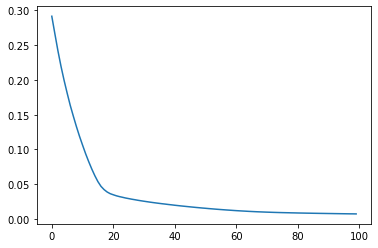

In [6]:
# 学習の実行
h = model.fit(x, y, epochs=100, verbose=0)

# 損失を観察してみる
plt.plot(h.history['loss'])

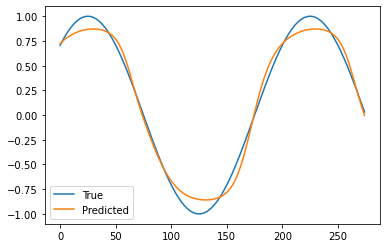

In [7]:
# 学習データで予測して正解と比較してみる
y_pre = model.predict(x)

# 結果を整形（1次元の配列にする）
y_true = y.reshape(-1)
y_pre  = y_pre.reshape(-1)

# 正解と予測結果をプロット
g = plt.subplot()
g.plot(y_true, label="True")
g.plot(y_pre, label="Predicted")
g.legend()

In [8]:
# 次に学習データの先の予測をしてみる

# 学習データの最後の25個を用意する
test_data = sine_data[-25:].copy()

predicted = []

# 200個予測することにする
for j in range(200):
    # 入力するデータを3階テンソルに変形
    d = np.reshape(test_data,(1,25,1))

    # このデータを入力して次を予測
    p = model.predict(d)

    # 結果を1次元にして格納
    p = p.reshape(-1)
    predicted.append(p)

    # 次の入力データを用意する
    # 最初の値つまり25個のうち最も古いものを予測結果で置き換えて
    test_data[0] = p
    # データを前方向に1つだけローテート（roll）すると，それが最後に移る
    test_data = np.roll(test_data, -1)

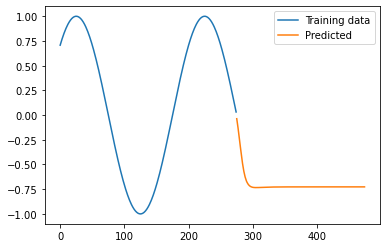

In [9]:
# 学習データとその先の予測した結果を続けてプロット
g = plt.subplot()
# 学習データ
m = list(range(len(y_true)))
g.plot(m, y_true, label="Training data")
# 予測結果
n = list(range(len(y_true), len(y_true) + 200))
g.plot(n, predicted, label="Predicted")
g.legend()

うまく学習できたとは言えないので，モデルの構成やパラメータをいろいろと変えて学習してみよう

# 実際の時系列データで試してみる

東京電力による1時間ごとの電力消費データ（2019年1月1日～12月31日）
https://www.tepco.co.jp/forecast/html/download-j.html

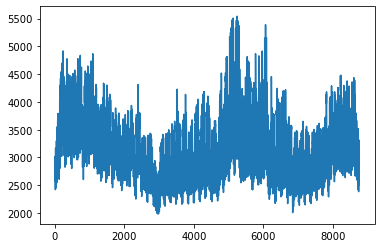

In [10]:
# CSVデータの読み込み
tepco_df = pd.read_csv('tepco-power2019.csv')

# 電力消費データ
tepco = np.array(tepco_df['POWER(10MW)'])
plt.plot(tepco)

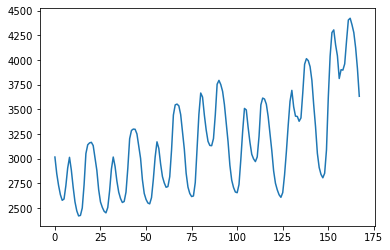

In [11]:
# はじめの1週間を拡大
plt.plot(tepco[0:24*7])

これも周期があるが，正弦波ほど単純ではない

In [12]:
# 学習データの準備（24時間分を入力することにする）
tx0, ty0 = prepare_batch(tepco, 24)

# 学習データ（約11ヶ月分）
tx = tx0[0:24*330]
ty = ty0[0:24*330]

# テストデータ（最後の約1ヶ月分）
ux = tx0[24*330:]
uy = ty0[24*330:]

計算に時間がかかる場合は，入力の長さ（24）や学習データのサイズ（24*330）を小さくする（当然ながら性能には影響がある）

Training time: 38.067 secs for 30 epoches (1.269 for each)


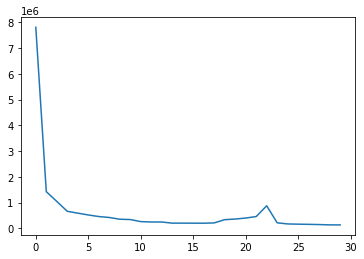

In [13]:
# モデルの定義
tepco_model = Sequential([
    # 値域が正で大きめなので，活性化関数をかけず恒等写像とする
    # また重みの初期値を固定値（0.3）にしておく
    LSTM(5, input_dim=1, activation=None, kernel_initializer=tensorflow.keras.initializers.constant(0.3)),
    # 出力層
    Dense(1, activation=None)
])

# 学習の設定
tepco_model.compile(loss='mse', optimizer=Adam())

# 学習の実行
e = 30
t1 = time.time()
h = tepco_model.fit(tx, ty, epochs=e, verbose=0)
t2 = time.time() - t1
print("Training time: %.3f secs for %d epoches (%.3f for each)" % (t2, e, t2/e))

# 損失を観察してみる
plt.plot(h.history['loss'])

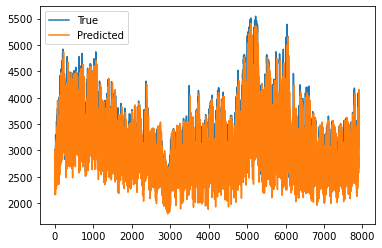

In [14]:
# 学習データで予測して正解と比較してみる
ty_pre = tepco_model.predict(tx)

# 結果を整形（1次元の配列にする）
ty_true = ty.reshape(-1)
ty_pre = ty_pre.reshape(-1)

# 正解と予測結果をプロット
g = plt.subplot()
g.plot(ty_true, label="True")
g.plot(ty_pre, label="Predicted")
g.legend()

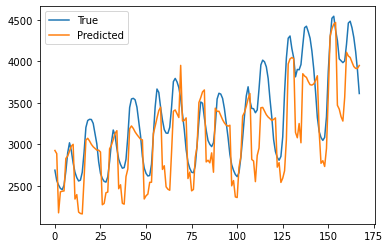

In [15]:
# はじめの1週間
g = plt.subplot()
g.plot(ty_true[0:24*7], label="True")
g.plot(ty_pre[0:24*7], label="Predicted")
g.legend()

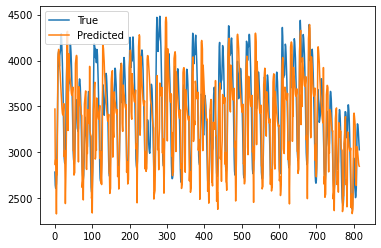

In [16]:
# テストデータで確認
uy_pre = tepco_model.predict(ux)
uy_pre = uy_pre.reshape(-1)
uy_true = uy.reshape(-1)

# 正解と予測結果をプロット
g = plt.subplot()
g.plot(uy_true, label="True")
g.plot(uy_pre, label="Predicted")
g.legend()

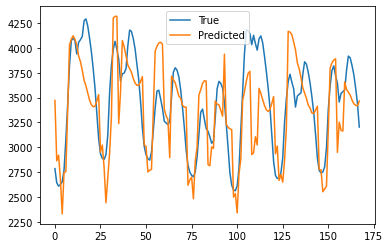

In [17]:
# はじめの1週間
g = plt.subplot()
g.plot(uy_true[0:24*7], label="True")
g.plot(uy_pre[0:24*7], label="Predicted")
g.legend()

周期性を学習できていることがわかる<br/>
こちらもモデルやパラメータを変えて試してみよう